## ASSESSMENT CARGOS ANALÍTICOS - DATA SCIENTIST

### Elaborado por: Juan Pablo Restrepo Lopera - juanpablorestrepolopera@gmail.com

### Introducción

A continuación, se resuelve el assessment para el cargo de Data Scientist de Teleperformance Colombia (feb/2021). Comencemos importando las librerías necesarias

### Librerías

In [1]:
#libreria | objetivo
import numpy as np  #manejo de matrices
import seaborn as sns #graficas
import matplotlib.pyplot as plt  #graficas
import pandas as pd   #manejo de dataframes
from sklearn.model_selection import train_test_split #para hacer el split aleatorio

import time #para tiempo de ejecución

from sklearn.linear_model import LogisticRegression #reg logistica
from sklearn.ensemble import RandomForestClassifier # RandomForest
from sklearn.metrics import confusion_matrix #matriz de confusión
from sklearn.metrics import accuracy_score #accuracy
from sklearn.metrics import f1_score #f1_score
from sklearn.metrics import roc_auc_score #area bajo la curva de la ROC
from sklearn.metrics import precision_score #precision_score
from sklearn.metrics import recall_score #recall_score

from sklearn.model_selection import GridSearchCV; #para la optimizacion de hiperparametros

In [2]:
%config IPCompleter.greedy = True #para que el notebook autocomplete
plt.style.use('Solarize_Light2') #ajustar estilo de matplotlib

### Importe de datos

Continuemos con la importación de los datos

In [3]:
df = pd.read_excel("Base de datos prueba tecnica.xlsx", sheet_name = 1) #se lee el excel en la hoja dos

In [4]:
df.head() #primeras filas

,REGIONAL,DEPARTAMENTO,TECNOL,GERENCIA,CANAL_HOMOLOGADO_MILLICON,tipo_fuerza_venta,estrato,antiguedad_meses,productos,portafolio,...,asesoria_factura,pedidos_peticiones,reagendamiento,asesoria_servicios,retencion,Otras,quejas_fraude,traslado,Incumplimiento_pago,cliente_id
0,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,...,0,0,0,0,0,0,0,0,0,1004369760
1,COSTA,MAGDALENA,HFC,CONTACT,SAC,INDIRECTA,3,19.0,TV+BA,Duo,...,0,0,0,0,0,0,0,0,0,1004369760
2,NOROCCIDENTE,ANTIOQUIA,HFC,CONTACT,SAC,INDIRECTA,1,1.0,TV,Individual,...,0,0,0,0,0,0,0,0,0,1004371304
3,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,...,0,0,0,0,0,0,0,0,1,1004382867
4,COSTA,MAGDALENA,HFC,CONTACT,IN BOUND,INDIRECTA,3,7.0,TO+TV+BA,Trio,...,0,0,0,0,0,0,0,0,1,1004382867


## Análisis exploratorio

Ahora realicemos un análisis exploratorio del dataframe. El siguiente comando permite conocer las variables, su tipo de dato y la cantidad de datos no-nulos

In [5]:
df.info()   #conocer los tipos de datos del dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19942 entries, 0 to 19941
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   REGIONAL                   19942 non-null  object 
 1   DEPARTAMENTO               19942 non-null  object 
 2   TECNOL                     19942 non-null  object 
 3   GERENCIA                   19942 non-null  object 
 4   CANAL_HOMOLOGADO_MILLICON  19942 non-null  object 
 5   tipo_fuerza_venta          19942 non-null  object 
 6   estrato                    19942 non-null  object 
 7   antiguedad_meses           18264 non-null  float64
 8   productos                  19942 non-null  object 
 9   portafolio                 19942 non-null  object 
 10  no_serv_tecnicos           6909 non-null   float64
 11  fallo                      6909 non-null   object 
 12  asesoria_factura           19942 non-null  int64  
 13  pedidos_peticiones         19942 non-null  int

Ahora se imputa el valor 'No reporta' para la variable 'fallo', el valor cero para la variable 'no_serv_tecnicos' y los valores nulos de la variable antiguedad_meses se reemplazan con la mediana.

In [6]:
df.fallo = df.fallo.replace(to_replace = [float('nan')], value = ['No reporta'])  #rellenar los nulos
df.no_serv_tecnicos = df.no_serv_tecnicos.replace(to_replace = [float('nan')], value = 0) #rellenar los nulos
antiguedad_meses_median = df.antiguedad_meses.median()  #calcula la mediana 
df['antiguedad_meses'] = df.antiguedad_meses.fillna(antiguedad_meses_median) #rellena la mediana 

Con el siguiente código se imprimen gráficos de barras para todas las variables, menos la variable 'cliente_id' y 'antiguedad_meses'

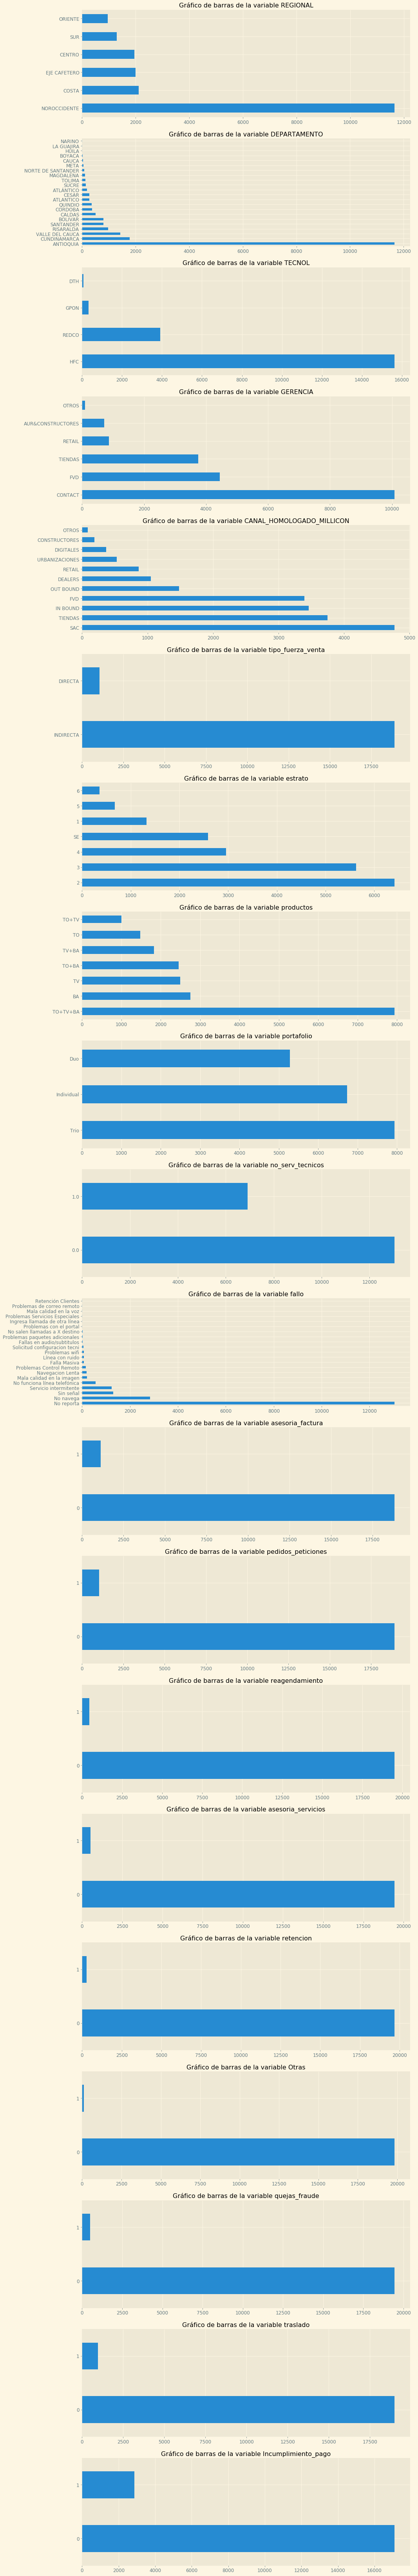

In [7]:
#Graficador de barras para todas las variables

cont = 0 #contador para el subplot
a = len(df.columns) #cantidad de columnas del dataframe
b = ((a + 2 - 1)//2)*2 #número de filas del subplot si se tienen una columna en el subplot
plt.gcf().set_size_inches(15, 6 * b) #ajuste del tamaño de las graficas

for i in df.columns: #for para grafico por columna
    
    if i != 'cliente_id' and i != 'antiguedad_meses': #dos excepciones
        
        plt.subplot(b, 1, cont + 1); #subplot
        df[i].value_counts().plot(kind = 'barh'); #grafico
        plt.title('Gráfico de barras de la variable ' + i); #titulo
        plt.xticks(fontsize = 12); #tamaño de letra
        plt.yticks(fontsize = 12); #tamaño de letra
        
        cont += 1 #aumento del contador para el subplot

La intención al graficar los anteriores gráficos de barras es conocer la distribución de las variables, ya que la gran mayoría son variables categóricas o binarias. 

De dichas gráficas puede afirmarse que los clientes de la muestra están sesgados en su ubicación geográfica en torno al noroccidente colombiano y al departamento de Antioquia.
A su vez, el tipo de tecnología predominante es la HFC, la cual es 4 veces más común que la REDCO. 

La gerencia de ventas más común es la CONTACT seguida por FVD y TIENDAS. 
El tipo de fuerza de venta más común es el INDIRECTO y los estratos más comunes son el 2 y el 3, esto último es coherente con la demografía colombiana. 

La opción de productos suscritos menos común es telefonía con televisión y el plan más común es el que incluye a los dos anteriores más el internet.

En fin, puede proseguirse con el análisis por variable, pero aprovechando la ley de los grandes números y asumiendo que la muestra es aleatoria, las siguientes tablas de contingencia son más
apropiadas que los gráficos de barras para concer la distribución de las variables:


In [8]:
for i in df.columns: #for para grafico por columna
    
    if i not in ['cliente_id', 'antiguedad_meses', 'Incumplimiento_pago', 
                 'DEPARTAMENTO', 'CANAL_HOMOLOGADO_MILLICON', 'fallo']: #excepciones
        
        print(pd.crosstab(index = df['Incumplimiento_pago'], columns = df[i]))

REGIONAL             CENTRO  COSTA  EJE CAFETERO  NOROCCIDENTE  ORIENTE   SUR
Incumplimiento_pago                                                          
0                      1512   1604          1840         10289      760  1082
1                       436    501           161          1351      190   216
TECNOL               DTH  GPON    HFC  REDCO
Incumplimiento_pago                         
0                     41   309  13314   3423
1                     28    20   2314    493
GERENCIA             AUR&CONSTRUCTORES  CONTACT   FVD  OTROS  RETAIL  TIENDAS
Incumplimiento_pago                                                          
0                                  553     8794  3385     89     750     3516
1                                  166     1281  1060      1     114      233
tipo_fuerza_venta    DIRECTA  INDIRECTA
Incumplimiento_pago                    
0                        758      16329
1                        291       2564
estrato                 1     2     

De las tablas de contingencia anteriores puede concluirse lo siguiente: 

* Las regiones EJE CAFETERO y NOROCCIDENTE tienen aproximadamente la mitad de propención que las demás regiones a entrar en mora.

* Los clientes con tecnología DTH son más de 6 veces más propensos que los de tecnología GPON a entrar en mora.

* En general, los clientes que entran en mora se comunican mucho menos con la empresa que los clientes que no entran en mora.

* Etcétera.

Ahora obtengamos el histograma para la única variable realmente numérica: 'antiguedad_meses'

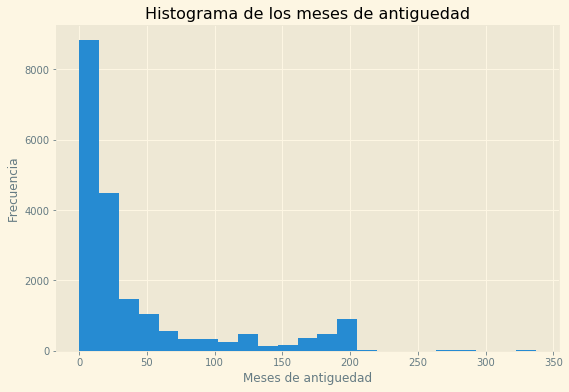

In [9]:
#histograma para la única variable realmente numérica

plt.figure(figsize = (9,6));
plt.hist(x = 'antiguedad_meses', data = df, bins = 'doane');
plt.title('Histograma de los meses de antiguedad');
plt.ylabel('Frecuencia');
plt.xlabel('Meses de antiguedad');

Del histograma anterior se detalla una sesgo de cola derecha y una distribución presuntamente bimodal

Ahora separemos el data frame en dos para conocer al individuo más típico que cae en mora y al más tipíco que no cae en mora:

In [10]:
#separar los dataframes entre los que incumplen y los que no
df_incumplen = df[df['Incumplimiento_pago'] == 1]
df_cumplen =  df[df['Incumplimiento_pago'] == 0]

In [11]:
def individio_tipico(data): 
    
    '''Esta función permite calcular el individuo más tipico de los dos dataframes anteriores'''

    diccionario = {}

    for i in data.columns:
    
        if i != 'cliente_id' and data[i].dtypes == 'O':

            diccionario[i] = data[i].mode().iloc[0]

        elif i != 'cliente_id':
            
            diccionario[i] = data[i].median() 

    print(diccionario)


In [12]:
individio_tipico(df_incumplen)

{'REGIONAL': 'NOROCCIDENTE', 'DEPARTAMENTO': 'ANTIOQUIA', 'TECNOL': 'HFC', 'GERENCIA': 'CONTACT', 'CANAL_HOMOLOGADO_MILLICON': 'FVD', 'tipo_fuerza_venta': 'INDIRECTA', 'estrato': 2, 'antiguedad_meses': 6.0, 'productos': 'TO+TV+BA', 'portafolio': 'Trio', 'no_serv_tecnicos': 0.0, 'fallo': 'No reporta', 'asesoria_factura': 0.0, 'pedidos_peticiones': 0.0, 'reagendamiento': 0.0, 'asesoria_servicios': 0.0, 'retencion': 0.0, 'Otras': 0.0, 'quejas_fraude': 0.0, 'traslado': 0.0, 'Incumplimiento_pago': 1.0}


In [13]:
individio_tipico(df_cumplen)

{'REGIONAL': 'NOROCCIDENTE', 'DEPARTAMENTO': 'ANTIOQUIA', 'TECNOL': 'HFC', 'GERENCIA': 'CONTACT', 'CANAL_HOMOLOGADO_MILLICON': 'SAC', 'tipo_fuerza_venta': 'INDIRECTA', 'estrato': 2, 'antiguedad_meses': 16.0, 'productos': 'TO+TV+BA', 'portafolio': 'Individual', 'no_serv_tecnicos': 0.0, 'fallo': 'No reporta', 'asesoria_factura': 0.0, 'pedidos_peticiones': 0.0, 'reagendamiento': 0.0, 'asesoria_servicios': 0.0, 'retencion': 0.0, 'Otras': 0.0, 'quejas_fraude': 0.0, 'traslado': 0.0, 'Incumplimiento_pago': 0.0}


El individio típico de los que incumplen no es tan diferente del individuo típico de los que cumplen. A primera vista la mayor diferencia se encuentra en los meses de antiguedad, la cual parece que será una variable importante, ya que la mediana de antiguedad de los clientes que incumplen es cerca de tres veces menor a la mediana de antiguedad de los clientes que no incumplen (es decir, los que cumplen).

### Preparación final del dataframe previa a la modelación

A continuación, se convierte el dataframe en una matriz que pueda ser empleada para la modelación. 

In [14]:
y = df['Incumplimiento_pago'] #se captura la variable de respuesta
df.drop(columns = ['Incumplimiento_pago', 'DEPARTAMENTO'], inplace = True) #se retiran dos variables: incumplimiento 
# porque no debe estar en las variables explicatiivas y Departamento porque tiene muchas categorías.
 
X = df.iloc[:, :-1] #se obtiene la matriz de variables explicativas, nótese que 'cliente_id' no se toma por obvias razones

In [15]:
#obtenemos las variables dummies

regional = pd.get_dummies(X['REGIONAL'])
tecnol = pd.get_dummies(X['TECNOL']) 
gerencia = pd.get_dummies(X['GERENCIA']) 
canal = pd.get_dummies(X['CANAL_HOMOLOGADO_MILLICON']) 
fuerza = pd.get_dummies(X['tipo_fuerza_venta']) 
estrato = pd.get_dummies(X['estrato']) 
productos = pd.get_dummies(X['productos']) 
portafolio = pd.get_dummies(X['portafolio']) 
fallo = pd.get_dummies(X['fallo']) 

X.drop(columns = ['REGIONAL', 'TECNOL', 'GERENCIA', 'CANAL_HOMOLOGADO_MILLICON', 
                   'tipo_fuerza_venta', 'estrato', 'productos', 'portafolio', 'fallo'], 
       inplace = True) #retiramos las variables que reemplazaremos por dummies

X = pd.concat([X, regional, tecnol, gerencia, canal, fuerza, estrato, 
              productos, portafolio, fallo], axis = 1) #concatenamos la matriz junto a las dummies

In [16]:
#Split aleatorio para la construcción del modelo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)

Nótese que se hicieron las siguientes modificaciones al conjunto de datos antes de comenzar la construcción del modelo: 

1. Imputación de variables al inicio del análisis exploratorio.

2. Eliminación de la variable Departamento por tener excesiva cantidad de categorías que no aportan más valor además del ya aportado por la variable de Región.

3. Obtención de variables dummies para: regional, tecnol, gerencia, canal, fuerza, estrato, productos, portafolio y fallo

4. Las variables que se emplean en el modelo parecen ser significativas según lo visto en el análisis exploratorio, con la excepción de algunos valores puntuales de la variable fallo. La que presuntamente será más significativa es 'antiguedad_meses'.


### Modelación

A continuación, se presenta el paso a paso para la construcción de un modelo para la predicción de la probabilidad de caer en mora.

### Línea base con Regresión Logistica

Lo siguiente es el ajuste de un modelo de regresión logística para trazar la línea base de rendimiento que deberá exigirsele a un modelo de clasificación más complejo que se desarrolle posteriormente: 

In [17]:
clf = LogisticRegression(max_iter = 1000, penalty = 'l2', C = 0.01) #se declara el modelo

In [18]:
clf.fit(X_train, y_train) #se entrena el modelo

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
y_pred_train = clf.predict(X_train) #se predice los valores de y_train

La siguiente función calcula varios parámetros de rendimiento de los modelos

In [20]:
def metricas(y_true, y_pred):
    
    '''Esta función permite calcular varios parámetros de rendimiento de los modelos'''
    
    print('accuracy_score: ' + str(accuracy_score(y_true, y_pred)))
    print('precision_score: ' + str(precision_score(y_true, y_pred)))
    print('recall_score: ' + str(recall_score(y_true, y_pred)))
    print('f1_score: ' + str(f1_score(y_true, y_pred)))
    print('roc_auc_score: ' + str(roc_auc_score(y_true, y_pred)))

In [21]:
metricas(y_train, y_pred_train)

accuracy_score: 0.8579411132602622
precision_score: 0.8536585365853658
recall_score: 0.01739562624254473
f1_score: 0.034096444227959086
roc_auc_score: 0.5084467040562352


A pesar del alto accuracy y la alta precisión, el modelo no resulta en uno muy bueno puesto que el área bajo de la curva de la ROC es de alrededor de 0.5, por lo que emplear el modelo o lanzar una moneda para predecir tiene exactamente el mismo resultado.

Evaluemos un modelo tipo Random Forest, aprovechando que dicho modelo es no-paramétrico al estar construido de árboles de decisión:

In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
metricas(y_train, y_pred_train)

accuracy_score: 0.9810158320796619
precision_score: 0.940494200706001
recall_score: 0.9269383697813122
f1_score: 0.9336670838548184
roc_auc_score: 0.9585307066115902


El modelo anterior es mucho más apropiado que el de la regresión logística. Procedamos con la evaluación del modelo en con el conjunto de datos de prueba.

In [23]:
y_pred_test = clf.predict(X_test)
metricas(y_test, y_pred_test)

accuracy_score: 0.9303025238174829
precision_score: 0.7933884297520661
recall_score: 0.6832740213523132
f1_score: 0.734225621414914
roc_auc_score: 0.8270455709874407


Parece que el modelo anterior tiende a sobreajustar. Sin embargo es un buen modelo con el que podría procederse con la optimización de hiperparámetros. Entrenemos el modelo con todos los datos y recalculemos las métricas:

In [24]:
clf = RandomForestClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)
metricas(y, y_pred)

accuracy_score: 0.9776351419115434
precision_score: 0.9346806207145435
recall_score: 0.9071803852889667
f1_score: 0.9207252044081052
roc_auc_score: 0.9482937684623566


El modelo por defecto tiene tan buen rendimiento que es aceptable proseguir sin optimizar los hiperparametros. Calculemos las probabilidades de no pagar: 

In [25]:
probabilidades = clf.predict_proba(X)
probabilidades_de_no_pago = [i[1] for i in probabilidades]

Ahora obtengamos un archivo csv con las probabilidades de no pago de cada cliente:

In [26]:
cliente = df['cliente_id']
data = {'cliente_id': cliente, 'probabilidades_de_no_pago': probabilidades_de_no_pago}
output = pd.DataFrame(data)
output = output.set_index('cliente_id')
output.to_csv('Probabilidades de no pago.csv')

A continuación, se obtiene el gráfico de importancia de cada variable o característica en el modelo, de la cual se detalla con especial interés a la variable 'antiguedad_meses' puesto que además de ser la más importante, es también la diferencia clave entre el individuo típico de los que caen en mora vs los que no caen en mora, como bien se concluyó en el análisis exploratorio.

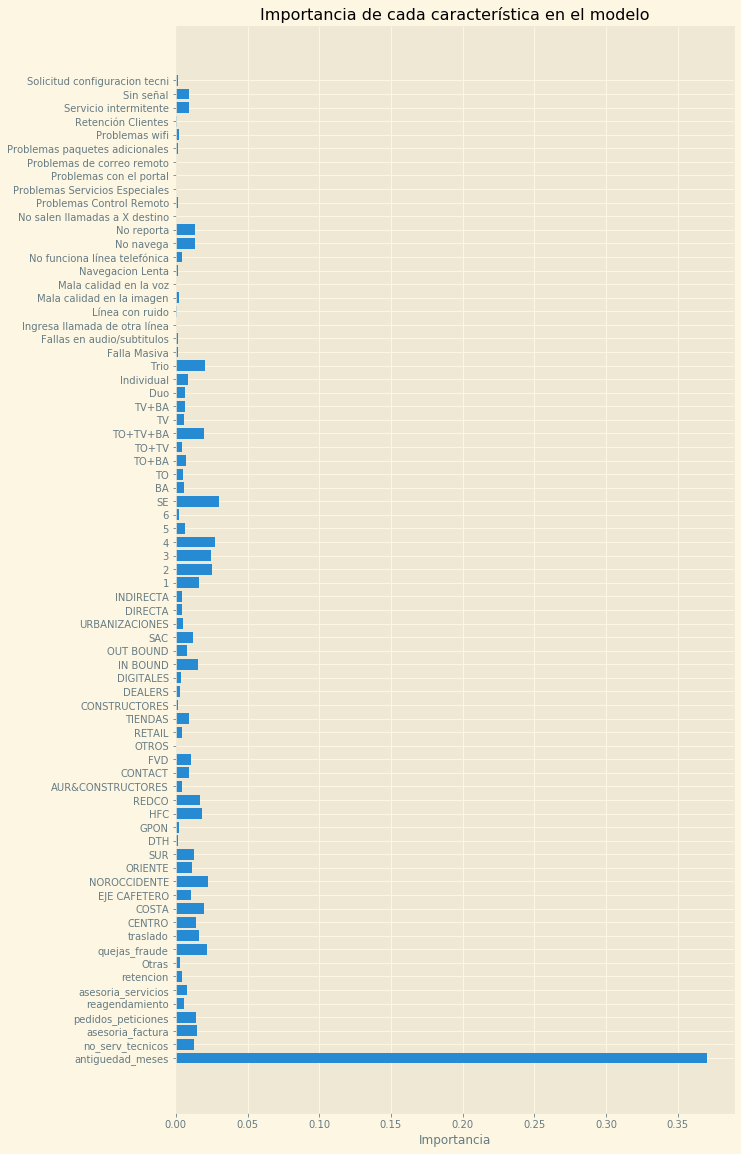

In [27]:
plt.figure(figsize = (10, 20));
plt.barh(y = [str(i) for i in np.array(X.columns)], width = clf.feature_importances_);
plt.title('Importancia de cada característica en el modelo');
plt.xlabel('Importancia');

### Puntos de corte de estrategia 

A continuación, se presenta el histograma de la probabilidad de no pago dividido en dos intervalos de probabilidad para obsevart mejor los detalles de la distribución.

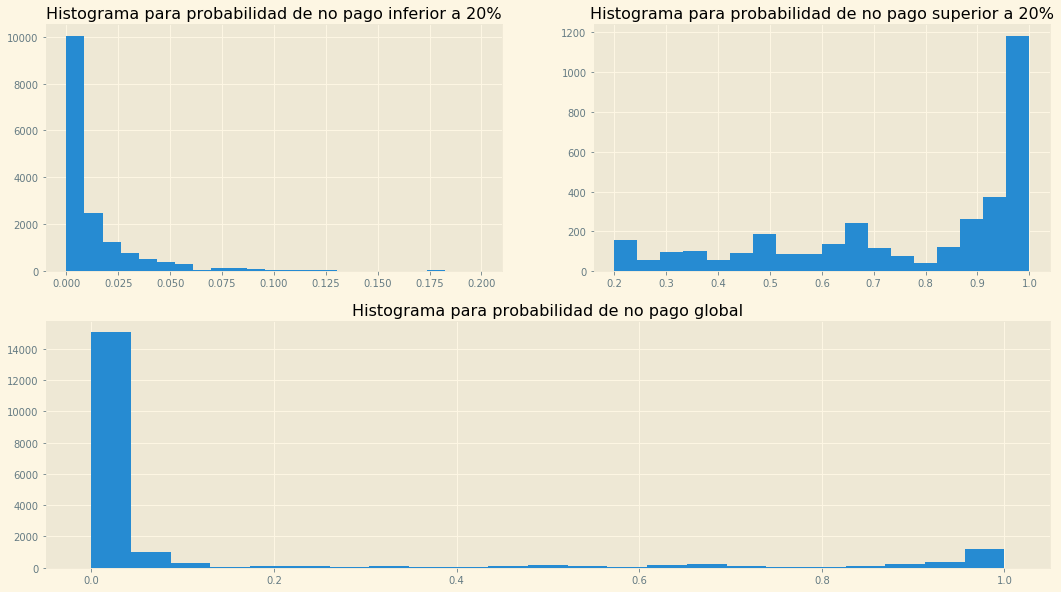

In [28]:
plt.gcf().set_size_inches(18, 10) #ajuste del tamaño de las graficas

plt.subplot(2, 2, 1); #subplot
plt.hist([i for i in probabilidades_de_no_pago if i <=0.2], bins = 'doane');
plt.title('Histograma para probabilidad de no pago inferior a 20%')
plt.subplot(2, 2, 2); #subplot
plt.title('Histograma para probabilidad de no pago superior a 20%')
plt.hist([i for i in probabilidades_de_no_pago if i >=0.2], bins = 'doane');
plt.subplot(2,1,2);
plt.title('Histograma para probabilidad de no pago global');
plt.hist(probabilidades_de_no_pago, bins = 'doane');

La distribución global de la probabilidad de no pago está muy sesgada hacia la derecha, lo cual representa bien la muestra de datos puesto que en el análisis exploratorio se detalló que quienes pagaban cumplidamente eran una cantidad mucho mayor a los que caen en mora. 

Establecer los umbrales para la estrategia de intervención es un problema que requiere al menos dos variables que son desconocidas para el ejercicio actual, uno es el presupuesto de las intervenciones y el otro es el estimado de recuperación de cartera por cliente intervenido. Con dichas variables se podría establecer un modelo simple de programación lineal que permitiera encontrar el óptimo del retorno de la inversión de la intervención. 

Por ahora, con la información disponible, la definición de los umbrales es un ejercicio mayormente subjetivo. No obstante se proponen los siguientes umbrales: 

1.	Alto riesgo: Aquellos cuya probabilidad de no pago supera el 60%
2.	Medio riesgo: Aquellos cuya probabilidad de no pago supera el 20% y es inferior al 60%
3.	Bajo riesgo:  Aquellos cuya probabilidad de no pago no supera el 20%


Las razones para proponer dichos umbrales radican en que el autor considera que una probabilidad de no pago del 20% es pequeña y por lo tanto manejable a partir de un mensaje de texto el día 15 de mora. A su vez, una calificación como alto riesgo para aquellos con probabilidad de no pago de 60% es apropiado puesto que la probabilidad de no pagar ya es superior a obtener sello en el lanzamiento de una moneda, es decir, muy probable.

Sin embargo, se reitera la importancia de plantear un problema simple de programación lineal en función del promedio de  recuperación de cartera por cliente intervenido y del presupuesto de la estrategia de intervención. 

A continuación, se calculan los perfiles típicos según el tipo de riesgo del cliente

In [29]:
tipo = []

for i in probabilidades_de_no_pago:
    
    if i >= 0.6:
        
        tipo.append('Alto')
    
    elif i<= 0.2:
        
        tipo.append('Bajo')
    
    else:
        
        tipo.append('Medio')

df['tipo'] = tipo

In [30]:
individio_tipico(df[df['tipo'] == 'Alto']) #perfil del cliente con riesgo alto

{'REGIONAL': 'NOROCCIDENTE', 'TECNOL': 'HFC', 'GERENCIA': 'CONTACT', 'CANAL_HOMOLOGADO_MILLICON': 'IN BOUND', 'tipo_fuerza_venta': 'INDIRECTA', 'estrato': 2, 'antiguedad_meses': 6.0, 'productos': 'TO+TV+BA', 'portafolio': 'Trio', 'no_serv_tecnicos': 0.0, 'fallo': 'No reporta', 'asesoria_factura': 0.0, 'pedidos_peticiones': 0.0, 'reagendamiento': 0.0, 'asesoria_servicios': 0.0, 'retencion': 0.0, 'Otras': 0.0, 'quejas_fraude': 0.0, 'traslado': 0.0, 'tipo': 'Alto'}


In [31]:
individio_tipico(df[df['tipo'] == 'Medio']) #perfil del cliente con riesgo medio

{'REGIONAL': 'NOROCCIDENTE', 'TECNOL': 'HFC', 'GERENCIA': 'FVD', 'CANAL_HOMOLOGADO_MILLICON': 'FVD', 'tipo_fuerza_venta': 'INDIRECTA', 'estrato': 2, 'antiguedad_meses': 5.0, 'productos': 'TO+TV+BA', 'portafolio': 'Trio', 'no_serv_tecnicos': 0.0, 'fallo': 'No reporta', 'asesoria_factura': 0.0, 'pedidos_peticiones': 0.0, 'reagendamiento': 0.0, 'asesoria_servicios': 0.0, 'retencion': 0.0, 'Otras': 0.0, 'quejas_fraude': 0.0, 'traslado': 0.0, 'tipo': 'Medio'}


In [32]:
individio_tipico(df[df['tipo'] == 'Bajo']) #perfil del cliente con riesgo bajo

{'REGIONAL': 'NOROCCIDENTE', 'TECNOL': 'HFC', 'GERENCIA': 'CONTACT', 'CANAL_HOMOLOGADO_MILLICON': 'SAC', 'tipo_fuerza_venta': 'INDIRECTA', 'estrato': 2, 'antiguedad_meses': 16.0, 'productos': 'TO+TV+BA', 'portafolio': 'Individual', 'no_serv_tecnicos': 0.0, 'fallo': 'No reporta', 'asesoria_factura': 0.0, 'pedidos_peticiones': 0.0, 'reagendamiento': 0.0, 'asesoria_servicios': 0.0, 'retencion': 0.0, 'Otras': 0.0, 'quejas_fraude': 0.0, 'traslado': 0.0, 'tipo': 'Bajo'}


De los tres comandos anteriores se desprende una conclusión importante y es que aquellos clientes con tipo de riesgo Bajo coinciden con aquellos que tienen mayor antiguedad. Por lo que es importante **sugerirle al equipo de cobranzas que preste  temprana atención a aquellos clientes que acaban de ser morosos y lleven menos de 6 meses en servicio, pues es muy probable que estos incumplan su pago.**

Entre los clientes tipicos con riesgo alto y riesgo bajo existen otro par de diferencias sutiles: los de riesgo alto en general tienen CANAL_HOMOLOGADO_MILLICON en valor IN BOUND mientras que los de riesgo bajo tienen SAC. 
A su vez,los de riesgo bajo típicamente tienen portafolio Individual, mientras que los de riesgo alto tienen portafolio Trio.

Ahora se revisa cuántos clientes de la muestra empleada corresponden a cada tipo de riesgo, tanto en cantidad como en porcentaje:

In [33]:
df['tipo'].value_counts()

Bajo     16463
Alto      2567
Medio      912
Name: tipo, dtype: int64

In [34]:
df['tipo'].value_counts()*100/len(df)

Bajo     82.554408
Alto     12.872330
Medio     4.573262
Name: tipo, dtype: float64

De lo anterior se detalla que los resultados son coherentes con el sesgo que tienen los datos de la muestra inicial, puesto que los de riesgo Bajo superan por casi 7 veces a los de riesgo 'Alto'.

Finalmente, respecto a la validez estadística del modelo es importante mencionar que los errores de generalización del modelo son pequeños y aceptables, tal como lo demuestra el valor del area bajo la curva ROC (0.82 en conjunto de datos de prueba), la cual representa el trade off entre sensitividad y especificidad.